# Exploración y Preparación de Datos

### Paso 1: Importar las librerías necesarias

In [1]:
# Manipulación y análisis de datos
import pandas as pd

# Interactuar con los servicios de AWS
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.sklearn.estimator import SKLearn
from sagemaker.sklearn.model import SKLearnModel

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Preparación de datos y modelos
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Guardar y cargar modelos
import joblib

# Operaciones del sistema operativo y manipulación de archivos
import os
import tarfile
import zipfile
import subprocess
import sys



sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


### Paso 2: Conectarse a S3 y descargar el archivo

En esta sección, nos conectamos al servicio S3 de AWS utilizando `boto3`, especificamos el nombre del bucket y el archivo que queremos descargar, y luego procedemos a descargarlo.


In [2]:
# Conectarse a S3
s3 = boto3.client('s3')
bucket_name = 'predicciontips'
file_key = 'tips.csv'

# Descargar el archivo
s3.download_file(bucket_name, file_key, 'tips.csv')

### Paso 3: Leer el archivo CSV en un DataFrame de pandas

Aquí leemos el archivo CSV que hemos descargado en un DataFrame de pandas para poder trabajar con los datos de manera más eficiente.


In [3]:
# Leer el archivo CSV en un DataFrame de pandas
tips = pd.read_csv('tips.csv')

# Mostrar las primeras filas del DataFrame para verificar que se haya cargado correctamente
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


### Paso 4: Aumentar el dataset generando datos sintéticos

En esta sección, aumentaremos el número de filas en nuestro dataset original generando datos sintéticos mediante el duplicado de filas existentes. Esto es útil para tener un conjunto de datos más grande para análisis y modelado.


In [4]:
# Número de filas actuales
current_rows = len(tips)

# Número de filas a agregar
additional_rows = 1000 - current_rows

# Generar datos sintéticos duplicando filas existentes
synthetic_data = tips.sample(additional_rows, replace=True, random_state=42)

# Combinar el dataset original con los datos sintéticos
tips_1000_rows = pd.concat([tips, synthetic_data], ignore_index=True)

# Verificar el nuevo número de filas
print(f"Número de filas en el dataset aumentado: {len(tips_1000_rows)}")

# Guardar el dataset aumentado
tips_1000_rows.to_csv('tips_1000_rows.csv', index=False)


Número de filas en el dataset aumentado: 1000


### Paso 5: Generar estadísticas descriptivas

Ahora que tenemos un dataset aumentado, vamos a generar estadísticas descriptivas para entender mejor la distribución de nuestros datos.


In [5]:
# Generar estadísticas descriptivas
tips_1000_rows.describe()

,total_bill,tip,size
count,1000.000000,1000.000000,1000.000000
mean,20.121520,2.981940,2.615000
std,8.995821,1.383432,0.962133
min,3.070000,1.000000,1.000000
25%,13.420000,2.000000,2.000000
50%,17.920000,2.830000,2.000000
75%,24.550000,3.550000,3.000000
max,50.810000,10.000000,6.000000


### Paso 6: Visualizar la distribución de variables

En esta sección, visualizaremos la distribución de las variables de interés utilizando histogramas, gráficos de cajas y gráficos de dispersión. Esto nos ayudará a entender mejor la distribución y relaciones en nuestros datos.


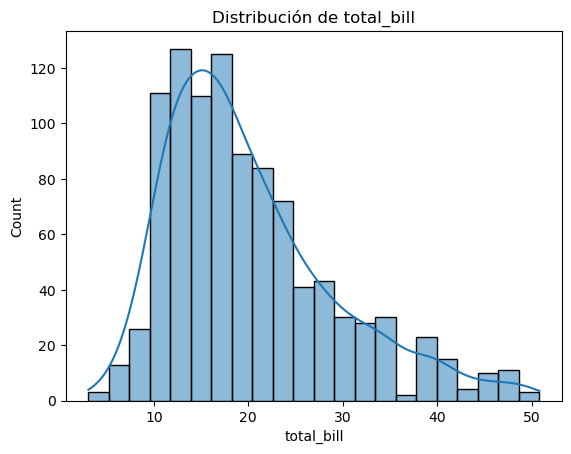

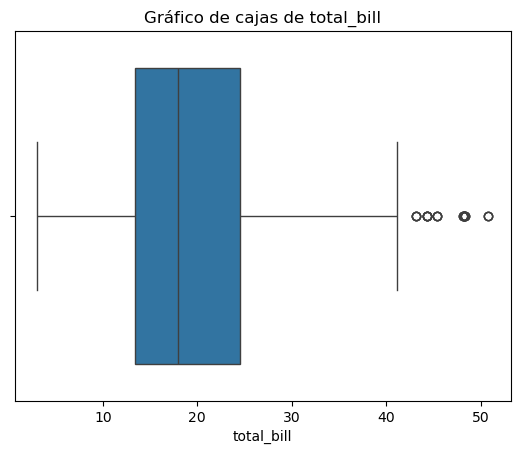

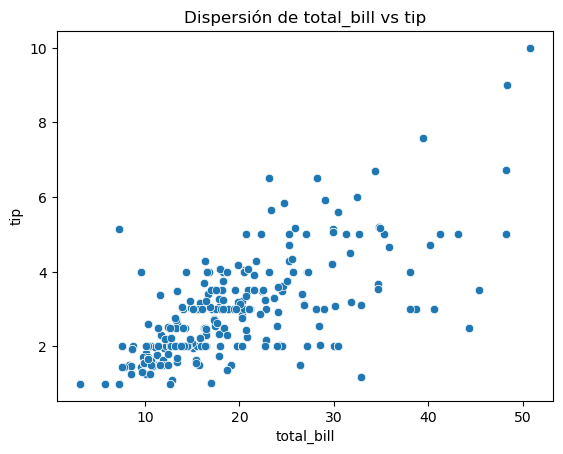

In [6]:
# Histograma
sns.histplot(tips_1000_rows['total_bill'], kde=True)
plt.title('Distribución de total_bill')
plt.show()

# Gráfico de cajas
sns.boxplot(x=tips_1000_rows['total_bill'])
plt.title('Gráfico de cajas de total_bill')
plt.show()

# Gráfico de dispersión
sns.scatterplot(x='total_bill', y='tip', data=tips_1000_rows)
plt.title('Dispersión de total_bill vs tip')
plt.show()

### Paso 7: Identificar valores nulos

Aquí verificamos si hay valores nulos en nuestro dataset, lo cual es crucial para asegurar la calidad de los datos antes de proceder con el análisis.


In [7]:
# Identificar valores nulos
tips_1000_rows.isnull().sum()

total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64

# Transformación de variables

### Paso 8: Normalizar datos numéricos

En esta sección, identificamos las características numéricas de nuestro dataset y las normalizamos utilizando `StandardScaler` para asegurarnos de que todas las características numéricas tengan una escala comparable.


In [8]:
numeric_features = tips_1000_rows.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_transformer = StandardScaler()

### Paso 9: Codificar datos categóricos

Aquí identificamos las características categóricas de nuestro dataset y las codificamos utilizando `OneHotEncoder` para convertir las categorías en una representación numérica que pueda ser utilizada por algoritmos de machine learning.


In [9]:
categorical_features = tips_1000_rows.select_dtypes(include=['object']).columns.tolist()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

### Paso 10: Crear el preprocesador con ColumnTransformer

Combinamos los transformadores numéricos y categóricos en un preprocesador único utilizando `ColumnTransformer`, lo que nos permite aplicar las transformaciones apropiadas a cada tipo de característica.


In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

### Paso 11: Dividir los datos en conjuntos de entrenamiento y prueba

Finalmente, dividimos nuestro dataset en conjuntos de entrenamiento y prueba utilizando `train_test_split` para poder evaluar el rendimiento de nuestros modelos de machine learning de manera adecuada.


In [11]:
train, test = train_test_split(tips_1000_rows, test_size=0.2, random_state=42)

### Paso 12: Crear el pipeline

En esta sección, creamos un pipeline que encapsula el preprocesador que hemos definido anteriormente. Esto facilita la aplicación coherente de las mismas transformaciones tanto a los datos de entrenamiento como a los datos de prueba.


In [12]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

### Paso 13: Aplicar el preprocesamiento a los datos de entrenamiento y prueba

Aplicamos el pipeline a los datos de entrenamiento y prueba para realizar las transformaciones definidas.


In [13]:
train_preprocessed = pipeline.fit_transform(train)
test_preprocessed = pipeline.transform(test)

### Paso 14: Convertir los datos preprocesados de vuelta a DataFrame para inspección

Convertimos los datos transformados de vuelta a DataFrames de pandas para facilitar la inspección y verificación.


In [14]:
cat_columns = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
train_preprocessed_df = pd.DataFrame(train_preprocessed, columns=numeric_features + list(cat_columns))
test_preprocessed_df = pd.DataFrame(test_preprocessed, columns=numeric_features + list(cat_columns))

### Paso 15: Mostrar las primeras filas del DataFrame preprocesado

Visualizamos las primeras filas de los DataFrames preprocesados para verificar que las transformaciones se hayan aplicado correctamente.


In [15]:
print(train_preprocessed_df.head())
print(test_preprocessed_df.head())

   total_bill       tip      size  sex_Female  sex_Male  smoker_No  \
0   -0.028330  0.015763 -0.632811         1.0       0.0        1.0   
1   -0.386031 -0.712738  1.480962         0.0       1.0        1.0   
2    0.610097  1.261500  1.480962         0.0       1.0        1.0   
3    2.131455  0.015763  1.480962         0.0       1.0        0.0   
4   -0.964464 -0.712738 -0.632811         1.0       0.0        1.0   

   smoker_Yes  day_Fri  day_Sat  day_Sun  day_Thur  time_Dinner  time_Lunch  
0         0.0      0.0      1.0      0.0       0.0          1.0         0.0  
1         0.0      0.0      0.0      1.0       0.0          1.0         0.0  
2         0.0      0.0      0.0      1.0       0.0          1.0         0.0  
3         1.0      0.0      1.0      0.0       0.0          1.0         0.0  
4         0.0      0.0      0.0      0.0       1.0          0.0         1.0  
   total_bill       tip      size  sex_Female  sex_Male  smoker_No  \
0   -1.127466 -1.033279 -0.632811        

### Paso 16: Guardar los datasets transformados en S3

Guardamos los DataFrames preprocesados en archivos CSV y los subimos a un bucket de S3 para su almacenamiento.


In [16]:
# Guardar los datasets transformados en S3
train_preprocessed_df.to_csv('/tmp/train.csv', index=False, header=True)
test_preprocessed_df.to_csv('/tmp/test.csv', index=False, header=True)


In [17]:
# Subir a S3
s3_client = boto3.client('s3')
s3_client.upload_file('/tmp/train.csv', 'predicciontips', 'train/train.csv')
s3_client.upload_file('/tmp/test.csv', 'predicciontips', 'test/test.csv')


# Entrenar el modelo

## Paso 17: Configurar y entrenar el modelo en SageMaker

En esta sección, configuramos un estimador de `sagemaker` para entrenar un modelo utilizando los datos preprocesados que hemos guardado en S3. Utilizaremos la clase `SKLearn` de SageMaker para ejecutar un script de entrenamiento que se encuentra en `train.py`.


In [18]:
# Obtener el rol de ejecución de SageMaker
role = sagemaker.get_execution_role()

# Especificar el bucket de S3 y los prefijos para los archivos de entrenamiento y prueba
bucket = 'predicciontips'
train_prefix = 'train'
test_prefix = 'test'

# Configurar el estimador de SKLearn
sklearn_estimator = SKLearn(
    entry_point='train.py',
    role=role,
    instance_type='ml.m4.xlarge',
    framework_version='0.23-1',
    sagemaker_session=sagemaker.Session(),
    hyperparameters={'alpha': 1.0, 'bucket': bucket}  # Hiperparámetros
)

# Entrenar el modelo en SageMaker
sklearn_estimator.fit({
    'train': f's3://{bucket}/{train_prefix}/train.csv',
    'test': f's3://{bucket}/{test_prefix}/test.csv'
})




INFO:sagemaker:Creating training-job with name: sagemaker-scikit-learn-2024-07-20-14-55-31-707


2024-07-20 14:55:32 Starting - Starting the training job...
2024-07-20 14:55:48 Starting - Preparing the instances for training...
2024-07-20 14:56:16 Downloading - Downloading input data...
2024-07-20 14:56:46 Downloading - Downloading the training image...
2024-07-20 14:57:21 Training - Training image download completed. Training in progress...2024-07-20 14:57:33,800 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2024-07-20 14:57:33,805 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-07-20 14:57:33,851 sagemaker_sklearn_container.training INFO     Invoking user training script.
2024-07-20 14:57:34,053 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-07-20 14:57:34,066 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-07-20 14:57:34,078 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-07-20 14

## Descargar Métricas y Predicciones desde S3

### Paso 18: Descargar métricas y predicciones

En esta sección, descargaremos las métricas y las predicciones generadas durante el entrenamiento del modelo desde un bucket de S3. Esto nos permitirá analizar los resultados del modelo.


In [19]:
# Definir el bucket de S3 y la ruta de las métricas y predicciones
bucket = 'predicciontips'
metrics_path = 'output/metrics.txt'
train_predictions_path = 'output/train_predictions.csv'
test_predictions_path = 'output/test_predictions.csv'

# Descargar los archivos
s3 = boto3.client('s3')
s3.download_file(bucket, metrics_path, '/tmp/metrics.txt')
s3.download_file(bucket, train_predictions_path, '/tmp/train_predictions.csv')
s3.download_file(bucket, test_predictions_path, '/tmp/test_predictions.csv')

### Paso 19: Leer y mostrar las métricas

Leemos el archivo de métricas descargado y mostramos su contenido para evaluar el rendimiento del modelo.


In [20]:
# Leer y mostrar las métricas
with open('/tmp/metrics.txt', 'r') as f:
    metrics = f.read()
    print(metrics)


Training Metrics:
Mean Squared Error: 0.5220824789320376
R^2: 0.47791752106796237
Mean Absolute Percentage Error: 312.235869800902

Test Metrics:
Mean Squared Error: 0.637953696013566
R^2: 0.40567902909756215
Mean Absolute Percentage Error: 374.8573831143076



### Paso 20: Leer y mostrar las predicciones

Leemos los archivos de predicciones descargados y mostramos las primeras filas para inspeccionar los resultados del modelo.


In [21]:
# Leer y mostrar las predicciones
train_predictions = pd.read_csv('/tmp/train_predictions.csv')
test_predictions = pd.read_csv('/tmp/test_predictions.csv')

print("Train Predictions:\n", train_predictions.head())
print("Test Predictions:\n", test_predictions.head())


Train Predictions:
      Actual  Predicted
0  0.015763  -0.078125
1 -0.712738  -0.054688
2  1.261500   0.578125
3  0.015763   1.382812
4 -0.712738  -0.609375
Test Predictions:
      Actual  Predicted
0 -1.033279  -0.718750
1 -1.076989  -0.757812
2  0.380014   0.304688
3 -0.858439  -0.539062
4 -0.712738  -0.710938


# Guardar y Subir el Modelo

### Paso 21: Guardar el modelo entrenado

En esta sección, guardaremos el modelo entrenado utilizando `joblib` y lo empaquetaremos en un archivo `.tar.gz` para facilitar su almacenamiento y transporte.


In [22]:
model = pipeline
model_path = "model.joblib"
joblib.dump(model, model_path)
print(f'Model saved as {model_path}')

Model saved as model.joblib


### Paso 22: Empaquetar el modelo en un archivo tar.gz

Utilizamos la librería `tarfile` para empaquetar el archivo del modelo en un archivo `.tar.gz`.


In [23]:
# Empaquetar el modelo en un archivo tar.gz
with tarfile.open('model.tar.gz', 'w:gz') as tar:
    tar.add('model.joblib', arcname='model.joblib')
print('Model tar.gz created')

Model tar.gz created


### Paso 23: Subir el archivo empaquetado a S3

Subimos el archivo `.tar.gz` a un bucket de S3 para su almacenamiento.


In [24]:
# Subir el archivo tar.gz a S3
s3_client = boto3.client('s3')
bucket = 'predicciontips'
model_tar_path = 'model/model.tar.gz'
s3_client.upload_file('model.tar.gz', bucket, model_tar_path)
print(f'Model tar.gz uploaded to s3://{bucket}/{model_tar_path}')


Model tar.gz uploaded to s3://predicciontips/model/model.tar.gz


# Descargar, Extraer y Cargar el Modelo desde S3

## Paso 24: Configurar el cliente de S3 y la información del archivo

Configuramos el cliente de S3 y especificamos la información del bucket y el objeto que vamos a descargar y extraer.


In [25]:
# Cliente de S3
s3 = boto3.client('s3')

# Información del bucket y el objeto
bucket_name = 'predicciontips'
object_key = 'model/model.tar.gz'
local_tar_path = 'model.tar.gz'
extract_to_path = 'model'


### Paso 25: Descargar el archivo desde S3

Definimos una función para descargar el archivo del modelo desde S3.


In [26]:
# Descargar el archivo desde S3
def download_model_from_s3(bucket, key, dest_path):
    s3 = boto3.client('s3')
    try:
        s3.download_file(bucket, key, dest_path)
        print(f"Modelo descargado correctamente desde s3://{bucket}/{key}")
    except Exception as e:
        print(f"Error al descargar el modelo: {e}")


### Paso 26: Extraer el archivo tar.gz

Definimos una función para extraer el archivo tar.gz descargado.


In [27]:
# Extraer el archivo tar.gz
def extract_model(tar_path, extract_to):
    try:
        with tarfile.open(tar_path, "r:gz") as tar:
            tar.extractall(path=extract_to)
        print(f"Modelo extraído en {extract_to}")
    except Exception as e:
        print(f"Error al extraer el modelo: {e}")



### Paso 27: Cargar el modelo

Definimos una función para cargar el modelo utilizando joblib.


In [28]:
# Cargar el modelo
def model_fn(model_dir):
    model_path = os.path.join(model_dir, "model.joblib")
    try:
        model = joblib.load(model_path)
        print("Modelo cargado exitosamente")
        return model
    except Exception as e:
        print(f"Error al cargar el modelo: {e}")


### Paso 28: Descargar, extraer y cargar el modelo

Utilizamos las funciones definidas para descargar, extraer y cargar el modelo.


In [29]:
# Descargar y extraer el modelo
download_model_from_s3(bucket_name, object_key, local_tar_path)
extract_model(local_tar_path, extract_to_path)

# Cargar el modelo
model = model_fn(extract_to_path)


Modelo descargado correctamente desde s3://predicciontips/model/model.tar.gz
Modelo extraído en model
Modelo cargado exitosamente


# Desplegar el Modelo en Lambda

###  Paso 29: Crear el Archivo de Código para Lambda (lambda_function.py)


### Paso 30: Crear el paquete ZIP para Lambda


In [30]:
# Función para crear el archivo ZIP para la función Lambda
def create_lambda_zip(zip_name, source_file):
    with zipfile.ZipFile(zip_name, 'w') as zipf:
        zipf.write(source_file, os.path.basename(source_file))
    print(f"{zip_name} creado exitosamente.")

# Empaquetar la función lambda_function.py
zip_file_name = 'lambda_deployment_package.zip'
source_file = 'lambda_function.py'
create_lambda_zip(zip_file_name, source_file)

lambda_deployment_package.zip creado exitosamente.


### Paso 31: Subir el paquete ZIP a S3

In [31]:
# Subir el archivo zip a S3
s3_client = boto3.client('s3')
bucket_name = 'predicciontips'
zip_file_s3_key = 'model/lambda_deployment_package.zip'

try:
    s3_client.upload_file(zip_file_name, bucket_name, zip_file_s3_key)
    print(f"Archivo {zip_file_name} subido a s3://{bucket_name}/{zip_file_s3_key}")
except boto3.exceptions.Boto3Error as e:
    print(f"Error al subir el archivo a S3: {e}")

Archivo lambda_deployment_package.zip subido a s3://predicciontips/model/lambda_deployment_package.zip


### Paso 32: Crear y configurar la función Lambda

In [32]:
# Parámetros de configuración
bucket_name = 'predicciontips'
zip_file_s3_key = 'model/lambda_deployment_package.zip'
role_arn = 'arn:aws:iam::280807576555:role/service-role/SageMaker-tip'
function_name = 'mySklearnLambdaFunction'

# Crear el cliente de Lambda
lambda_client = boto3.client('lambda')

### Paso 33: Crear la función Lambda


In [33]:
# Crear o actualizar la función Lambda
def create_or_update_lambda_function():
    try:
        # Verificar si la función Lambda ya existe
        lambda_client.get_function(FunctionName=function_name)
        # Si existe, actualizar el código de la función
        response = lambda_client.update_function_code(
            FunctionName=function_name,
            S3Bucket=bucket_name,
            S3Key=zip_file_s3_key,
            Publish=True
        )
        print(f"Función Lambda actualizada: {response['FunctionArn']}")
    except lambda_client.exceptions.ResourceNotFoundException:
        # Si no existe, crear la función
        response = lambda_client.create_function(
            FunctionName=function_name,
            Runtime='python3.8',
            Role=role_arn,
            Handler='lambda_function.lambda_handler',
            Code={
                'S3Bucket': bucket_name,
                'S3Key': zip_file_s3_key,
            },
            Timeout=300,  # 5 minutos de timeout
            MemorySize=128,  # 128 MB de memoria
        )
        print(f"Función Lambda creada: {response['FunctionArn']}")
    except lambda_client.exceptions.InvalidParameterValueException as e:
        print(f"Error al crear o actualizar la función Lambda: {e}")
    except Exception as e:
        print(f"Error inesperado: {e}")

create_or_update_lambda_function()


Función Lambda actualizada: arn:aws:lambda:us-east-1:280807576555:function:mySklearnLambdaFunction:1
